In [1]:
import qctoolkit as qtk
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from copy import deepcopy
import horton as ht
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import UnivariateSpline
from glob import glob
import os
from scipy.interpolate import spline
from scipy.interpolate import interp2d

#Note inline and notebook is contradicting to each other
%matplotlib notebook

missing file: mov2asc
please modify /path/to/qctoolkit/setting.py and recompile.


/home/samio/local/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
###############
# color tests #
###############

mcolors = mpl.colors
#colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = dict(mcolors.BASE_COLORS)

by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
by_hsv

[((0.0, 0.0, 0.0), u'k'),
 ((0.0, 0.0, 1.0), u'w'),
 ((0.0, 1.0, 1.0), u'r'),
 ((0.16666666666666666, 1.0, 0.75), u'y'),
 ((0.3333333333333333, 1.0, 0.5), u'g'),
 ((0.5, 1.0, 0.75), u'c'),
 ((0.6666666666666666, 1.0, 1.0), u'b'),
 ((0.8333333333333334, 1.0, 0.75), u'm')]

# General 2D projection for exploration

In [3]:
data_N2_ZR = np.load('old/data_N2_RZ_ccsdt.npz')
#data_N2_ZZ = np.load('data_N2_ccsd.npz')
data_N2_ZZ = np.load('old/data_N2_ccsdt_wocharge.npz')
data_N2_3D = np.load('old/data_N2_3D_ZZR_pbe.npz')

In [4]:
def list2mesh(data=None, E=None, X=None):
    if data is not None:
        X = data['X']
        E = data['E']
    X_lists = [sorted(set(X[:,i])) for i in range(X.shape[1])]
    X_meshes = np.array(np.meshgrid(*X_lists, indexing='ij'))
    E_mesh = np.zeros(X_meshes[0].shape)
    for s, e in enumerate(E):
        inds = tuple([np.argmin(abs(np.array(arr) - X[s][i])) for i, arr in enumerate(X_lists)])
        E_mesh[inds] = e
    return X_meshes, E_mesh

In [5]:
def E_2D(data, axes=[0,1], axes_names=None, ax=None, get_mesh=False, **kwargs):
    
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        
    if type(data) is np.lib.npyio.NpzFile:
        X_all, E = data['X'], data['E']
        try:
            axes_names = data['axes']
        except:
            pass
        X = np.array([[x[axes[0]], x[axes[1]]] for x in X_all])
        x = sorted(set(X[:,0]))
        y = sorted(set(X[:,1]))
        x_mesh, y_mesh = np.meshgrid(x, y, indexing='ij')
        E_mesh = np.zeros(x_mesh.shape)
        for s, e in enumerate(E):
            i = x.index(X_all[s][axes[0]])
            j = y.index(X_all[s][axes[1]])
            E_mesh[i,j] = e
    else:
        E_mesh = data['E_mesh']
        x_mesh = data['x_mesh']
        y_mesh = data['y_mesh']
    
    ax.plot_wireframe(x_mesh, y_mesh, E_mesh, **kwargs)
    ax.set_zlabel('E')
    
    if axes_names is None:
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    else:
        ax.set_xlabel(axes_names[axes[0]])
        ax.set_ylabel(axes_names[axes[1]])
        
    if get_mesh:
        return ax, x_mesh, y_mesh, E_mesh
    else:
        return ax

<IPython.core.display.Javascript object>


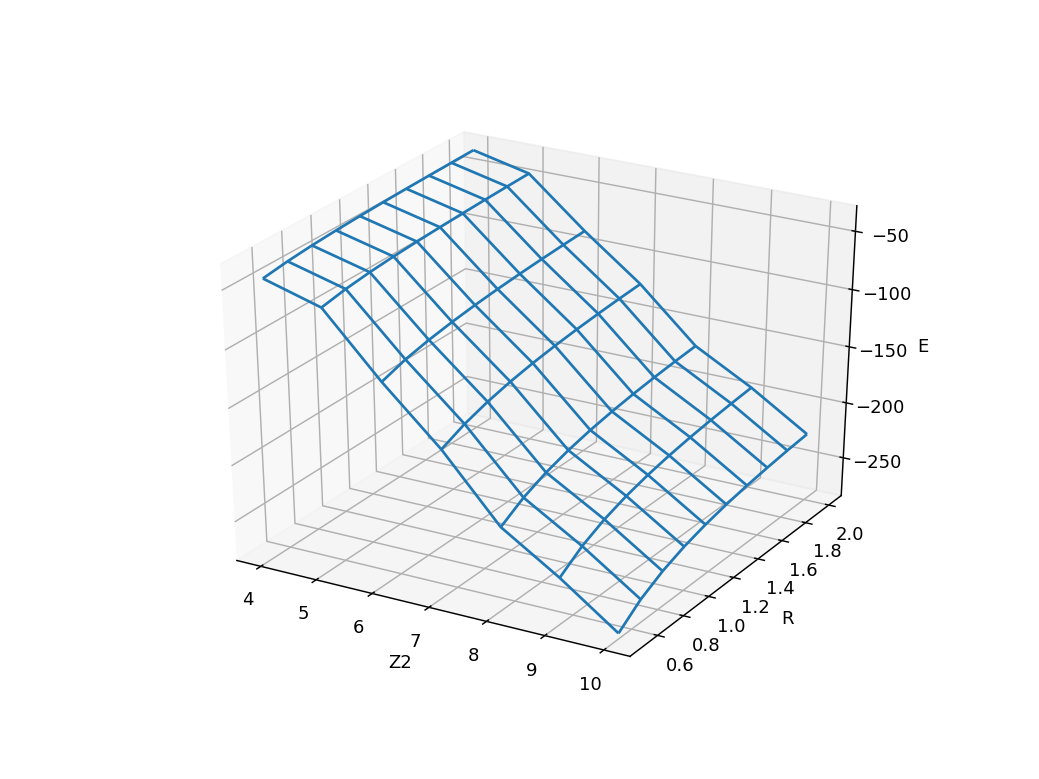

In [6]:
E_2D(data_N2_3D, axes=[1,2])

<IPython.core.display.Javascript object>


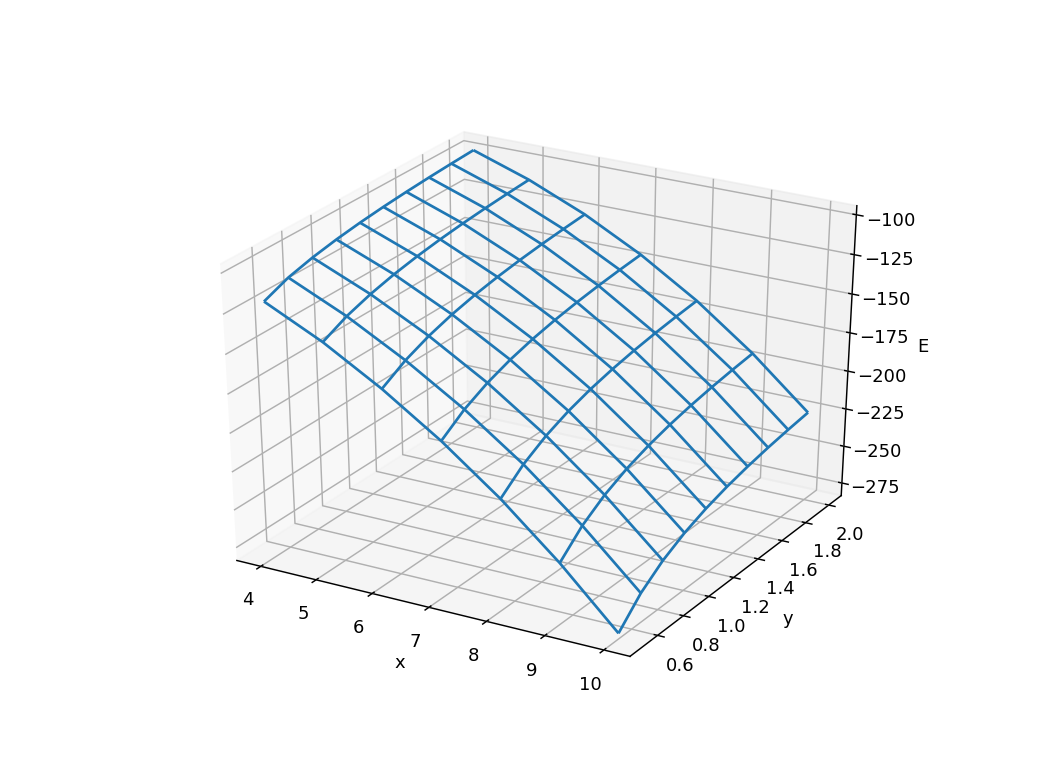

In [7]:
Xs, E = list2mesh(data_N2_3D)
test_data = {'x_mesh': Xs[0][:,4,:], 'y_mesh': Xs[2][:,4,:], 'E_mesh': E[:,4,:]}
E_2D(test_data)

# explort 3D neutral surface

In [8]:
data_pbe = np.load('gaussian_N2_pbe.npz')
data_pbe.keys()
En = data_pbe['E_neutral']
Xn = data_pbe['X_neutral']
dx = data_pbe['dx']
gn2, hn2 = data_pbe['g_N2'], data_pbe['h_N2']
gco, hco = data_pbe['g_CO'], data_pbe['h_CO']
gbf, hbf = data_pbe['g_BF'], data_pbe['h_BF']

In [9]:
data_pbe_HAl = np.load('gaussian_N2_pbe_H-Al.npz')
En = data_pbe_HAl['E_neutral']
Xn = data_pbe_HAl['X_neutral']
dx = data_pbe_HAl['dx']
g_list, h_list = data_pbe_HAl['g_list'], data_pbe_HAl['h_list']

In [10]:
data_diff_largedZ = np.load('gaussian_diff_largedZ.npz')
g_list, h_list = data_diff_largedZ['g_list'], data_diff_largedZ['h_list']
dx = data_diff_largedZ['dx']

In [11]:
data_diff_dZ03 = np.load('gaussian_diff_dZ03.npz')
g_list, h_list = data_diff_dZ03['g_list'], data_diff_dZ03['h_list']
dx = data_diff_largedZ['dx']

In [12]:
Xn_meshes, E_mesh = list2mesh(E=En, X=Xn)

<IPython.core.display.Javascript object>


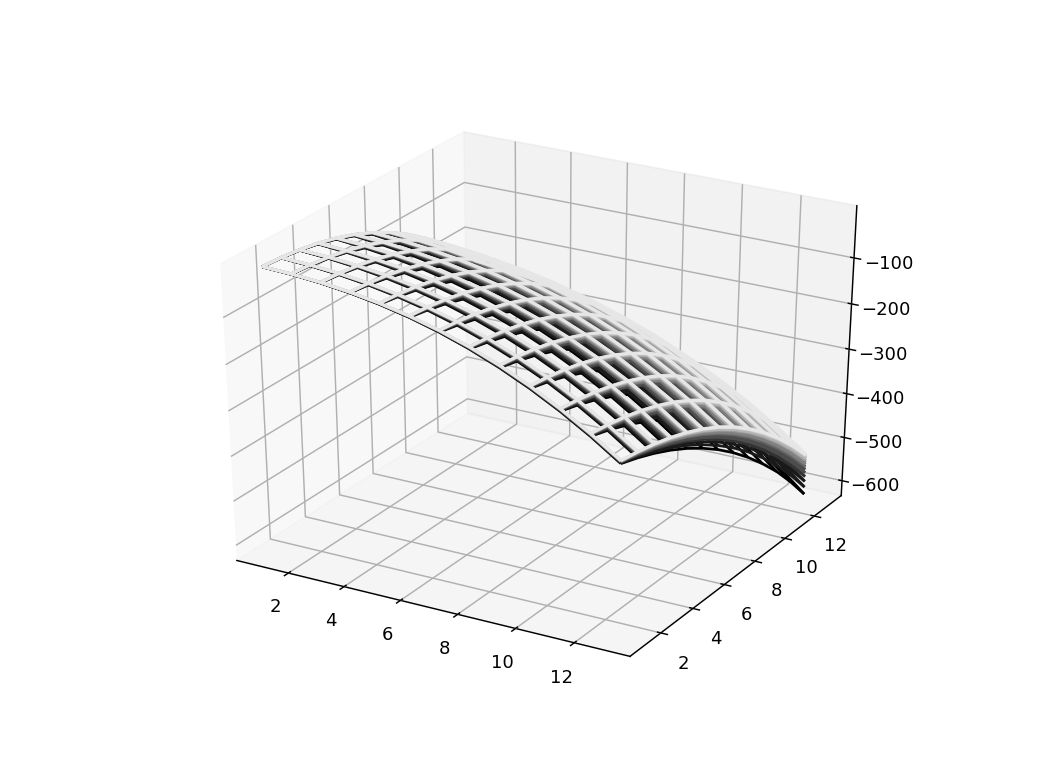

In [13]:
Z1_mesh = Xn_meshes[0][:,:,0]
Z2_mesh = Xn_meshes[1][:,:,0]
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for ri in range(E_mesh.shape[-1]):
    # colro: 1.0=white, 0.0=black
    c = '%3.1f' % (float(ri) / E_mesh.shape[-1])
    #c = '0.0'
    ax.plot_wireframe(Z1_mesh, Z2_mesh, E_mesh[:,:,ri], color=c)

# Error plot

In [14]:
data_pbe_HAl = np.load('gaussian_N2_pbe_H-Al.npz')
En = data_pbe_HAl['E_neutral']
Xn = data_pbe_HAl['X_neutral']
dx = data_pbe_HAl['dx']
g_list, h_list = data_pbe_HAl['g_list'], data_pbe_HAl['h_list']

In [15]:
data_diff_dZ03 = np.load('gaussian_diff_dZ03.npz')
g_list, h_list = data_diff_dZ03['g_list'], data_diff_dZ03['h_list']
dx = data_diff_dZ03['dx']

In [16]:
data_diff_largedZ = np.load('gaussian_diff_largedZ.npz')
g_list, h_list = data_diff_largedZ['g_list'], data_diff_largedZ['h_list']
dx = data_diff_largedZ['dx']

In [17]:
data_diff_dZ005_ht = np.load('gaussian_diff_dZ005_ht.npz')
g_list, h_list = data_diff_dZ005_ht['g_list'], data_diff_dZ005_ht['h_list']
dx = data_diff_dZ005_ht['dx']

In [18]:
data_diff_dZ005_ht = np.load('gaussian_diff_dZ03_ht.npz')
g_list, h_list = data_diff_dZ005_ht['g_list'], data_diff_dZ005_ht['h_list']
dx = data_diff_dZ005_ht['dx']

In [19]:
data_diff_sb = np.load('gaussian_pbe_same_basis.npz')
g_list, h_list = data_diff_sb['g_list'], data_diff_sb['h_list']
dx = data_diff_sb['dx']

In [20]:
Xn_meshes, E_mesh = list2mesh(E=En, X=Xn)

In [21]:
R_list = Xn_meshes[2][0,0,:]
R_ref = 1.1 * qtk.setting.a2b
dR_list = R_list - R_ref
r0_i = np.arange(len(R_list))[dR_list == 0][0]

In [22]:
def get_zz_coord(X_meshes, dz=0, dR=None):
    dZ = X_meshes[1][0,:,0] - (7-dz)
    Z_coord = np.asarray(zip(dZ, (dZ-2*dz)[::-1]))
    if dR is None:
        return Z_coord
    else:
        return np.hstack([Z_coord, (np.ones(len(Z_coord)) * dR)[:,np.newaxis]])
get_zz_coord(Xn_meshes, 0, 0.1)

array([[-6. ,  6. ,  0.1],
       [-5. ,  5. ,  0.1],
       [-4. ,  4. ,  0.1],
       [-3. ,  3. ,  0.1],
       [-2. ,  2. ,  0.1],
       [-1. ,  1. ,  0.1],
       [ 0. ,  0. ,  0.1],
       [ 1. , -1. ,  0.1],
       [ 2. , -2. ,  0.1],
       [ 3. , -3. ,  0.1],
       [ 4. , -4. ,  0.1],
       [ 5. , -5. ,  0.1],
       [ 6. , -6. ,  0.1]])

In [23]:
def get_E_ref(E_mesh, r_ref_ind):
    # center N2 Z index
    Z0_ind = (E_mesh.shape[0] - 1) / 2
    # reference energies
    E0 = [E_mesh[Z0_ind-i,Z0_ind+i,r_ref_ind] for i in range(Z0_ind+1)]
    return E0
E0 = get_E_ref(E_mesh, r0_i)
E0

[-132.98841459552727,
 -136.28302750378182,
 -146.12718012854546,
 -162.42543996981817,
 -185.1804058276,
 -214.09239870189091,
 -248.9452626926909]

[[-5.   5.   0.1]
 [-4.   4.   0.1]
 [-3.   3.   0.1]
 [-2.   2.   0.1]
 [-1.   1.   0.1]
 [ 0.   0.   0.1]
 [ 1.  -1.   0.1]
 [ 2.  -2.   0.1]
 [ 3.  -3.   0.1]
 [ 4.  -4.   0.1]
 [ 5.  -5.   0.1]
 [ 6.  -6.   0.1]
 [ 7.  -7.   0.1]]


<IPython.core.display.Javascript object>


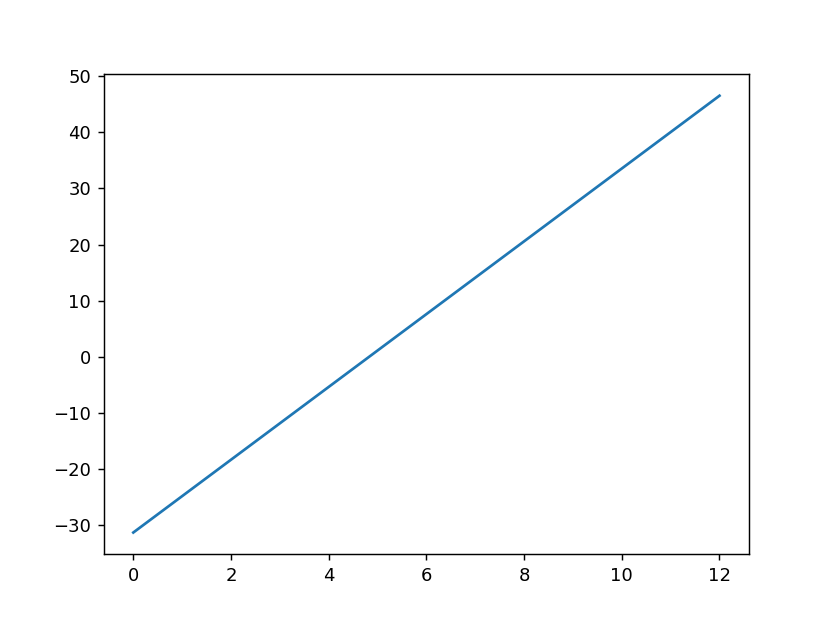

In [24]:
def energy_estimate(coords, g_in, h_in, factor_2nd=2., order=2, scale=1.0):
    dim = len(coords[0])
    g = g_in[:dim]
    h = h_in[:dim, :dim]
    if order==2:
        return coords.dot(g) + scale * np.einsum('ij,ij->i', coords.dot(h), coords) / factor_2nd
    else:
        return coords.dot(g)
    
dz = 1
test_coords = get_zz_coord(Xn_meshes, dz, 0.1)
print test_coords
plt.figure()
plt.plot(energy_estimate(test_coords, g_list[dz], h_list[dz], order=1))

In [25]:
def E_zz_diag(E_mesh, X_meshes, g, h, dz_list, dr_list=[0], r_ref=2.0786985879, order=2, scale=1.0):

    
    R_list = Xn_meshes[2][0,0,:]
    r_ref_ind = np.argmin(abs(R_list - r_ref))
    dR_list = R_list - R_list[r_ref_ind]
    
    E_prd = []
    E_tar = []
    E0 = get_E_ref(E_mesh, r_ref_ind)
    
    for dr in dr_list:
        dr_ind = np.argmin(abs((R_list - r_ref) - dr))
        E_tar_ri = []
        E_tar.append(E_tar_ri)
        E_prd_ri = []
        E_prd.append(E_prd_ri)
        for i, dz in enumerate(dz_list):
            ZR_coord = get_zz_coord(Xn_meshes, dz, dr)
            Ep = energy_estimate(ZR_coord, g[int(dz)], h[int(dz)], order=order, scale=scale) + E0[int(dz)]
            E_prd_ri.append(Ep)
        for i in range(E_mesh.shape[0]):
            E_tar_ri.append(E_mesh[i,(E_mesh.shape[0]-1)-i,dr_ind])
            
    E_tar = np.asarray(E_tar)
    E_prd = np.asarray(E_prd)
    return E_tar, E_prd, E0

In [26]:
E_tar, E_prd, E0 = E_zz_diag(E_mesh, Xn_meshes, g_list, h_list, dz_list=range(len(g_list)), dr_list=dR_list, order=1)
print E_tar.shape
print E_prd.shape

(15, 13)
(15, 7, 13)


In [27]:
# dZ_N2 = Xn_meshes[1][0,:,0] - 7
# Z_coord_N2 = np.asarray(zip(dZ_N2, dZ_N2[::-1]))
# dZ_CO = Xn_meshes[1][0,:,0] - 6
# Z_coord_CO = np.asarray(zip(dZ_CO, (dZ_CO-2)[::-1]))
# dZ_BF = Xn_meshes[1][0,:,0] - 5
# Z_coord_BF = np.asarray(zip(dZ_BF, (dZ_BF-4)[::-1]))
# Z_coords = np.array([Z_coord_N2, Z_coord_CO, Z_coord_BF])
# dR = Xn_meshes[2][0,:,6] - 1.1

In [28]:
# test_ZR = np.hstack([Z_coords[0], dR[:, np.newaxis]])
# print energy_estimate(test_ZR, gn2, hn2)
# print energy_estimate(Z_coords[0], gn2, hn2)

In [29]:
E_tar, E_prd, E0 = E_zz_diag(E_mesh, Xn_meshes, g_list, h_list, dz_list=range(len(g_list)), dr_list=dR_list)
print E_tar.shape
print E_prd.shape

(15, 13)
(15, 7, 13)


<IPython.core.display.Javascript object>


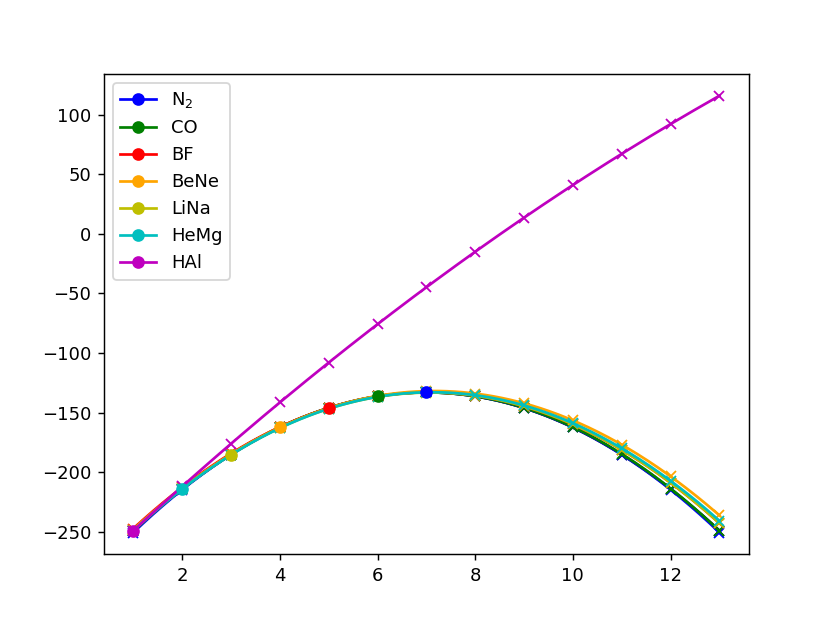

7.0


In [30]:
E_tar, E_prd, E0 = E_zz_diag(E_mesh, Xn_meshes, g_list, h_list, dz_list=range(len(g_list)), dr_list=dR_list)

colors = ['b', 'g', 'r', 'orange', 'y' ,'c', 'm']
labels = [r'N$_2$', 'CO', 'BF','BeNe', 'LiNa', 'HeMg', 'HAl']
def E_zz_2D_fit(E_tar, E_prd, dr_ind, x=None, dz_list=None, ax=None, 
                colors=colors,labels=labels
               ):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    if x is None:
        x = np.arange(len(E_tar[dr_ind])) + 1
    print np.mean(x)
    x_min, x_max = min(x), max(x)
    x_new = np.linspace(x_min, x_max, 300)
    
    if dz_list is None:
        dz_list = (np.arange(len(E_tar[dr_ind])) + 1).as_type(int)
    
    def smooth(y, **kwargs):
        kwargs = deepcopy(kwargs)
        ax.plot(x, y, ls='', **kwargs)
        y_new = spline(x, y, x_new)
        for key in 'marker', 'label':
            if key in kwargs:
                kwargs[key] = None
        ax.plot(x_new, y_new, **kwargs)
    
    smooth(E_tar[dr_ind], color='k', marker='x')
    #y = E_tar[dr_ind]
    #ax.plot(x, y, color='k', marker='x')
    #ax.plot(x_new, y_new, color='k')
    
    for i in range(len(colors), len(E_prd[dr_ind]) + 1):
        colors.append(colors[-1])
        labels.append('')
    
    for i, e in enumerate(E_prd[dr_ind]):
        #ax.plot(x, e, ls='', marker='x', color=colors[i])
        smooth(e, marker='x', color=colors[i])
        
    for i, z in enumerate(dz_list):
        #ax.plot([np.mean(x)-z], [E0[z]], marker='o', color=colors[i], label=labels[dz_list[i]])
        ax.plot([np.mean(x)-z], [E_tar[dr_ind][6-z]], marker='o', color=colors[i], label=labels[dz_list[i]])
    return ax
        
#dz_list = [0,1,2,4,5]
dz_list = range(7)
E_tar, E_prd, E0 = E_zz_diag(E_mesh, Xn_meshes, g_list, h_list, dz_list=dz_list, dr_list=dR_list, order=2)
ax = E_zz_2D_fit(E_tar, E_prd, 5, dz_list=dz_list)
ax.legend()
# _dx = 0.05
# ax.set_xlim(3-_dx, 3+_dx)
# ax.set_ylim(-187, -185)

In [31]:
h_list[-1][:2,:2]

array([[-1.00121342, -0.90537425],
       [-0.90537425, -2.01823195]])

In [32]:
np.round(h_list[-1][:2,:2], decimals=2)

array([[-1.  , -0.91],
       [-0.91, -2.02]])

In [33]:
[np.linalg.eigh(h_list[i][:2,:2])[0][1] for i in range(len(h_list))]

[-2.987344120712531,
 -2.730246383196069,
 -2.403501704021041,
 -2.224094326982904,
 -2.1426119498023573,
 -1.8753349440032292,
 -0.4713180398692376]

In [34]:
def fit_error(E_tar, E_prd, ri, x=None, dz_list=[0], ax=None, prd_colors = colors, dz=1, nz=None, get_error=False, **kwargs):
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    if nz is None:
        nz = len(dz_list)
        
    x = np.array([0, 1])
    
    #err = E_tar[ri] - E_prd[ri]

    width = .95 / nz
    
    err_all = []
    for i, z in enumerate(dz_list):
        err = E_tar[ri] - E_prd[ri][i]
        z0 = np.argmin(abs(err))
        neighbor_err = np.take(err, [z0-dz, z0+dz])
        err_all.append(neighbor_err)
        #ax.bar(x + width * i, neighbor_err, width, color=prd_colors[i])
        ax.bar(x + width * i, [err[z0-dz], err[z0+dz]], width, color=prd_colors[i], **kwargs)
    err_all = np.asarray(err_all)
        
    if not get_error:
        return ax
    else:
        return ax, err_all

<IPython.core.display.Javascript object>


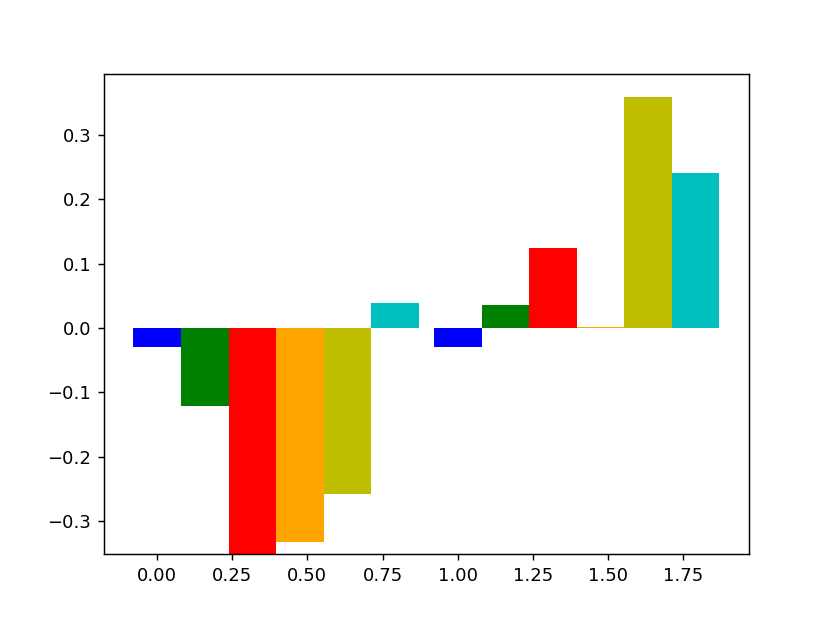

<IPython.core.display.Javascript object>


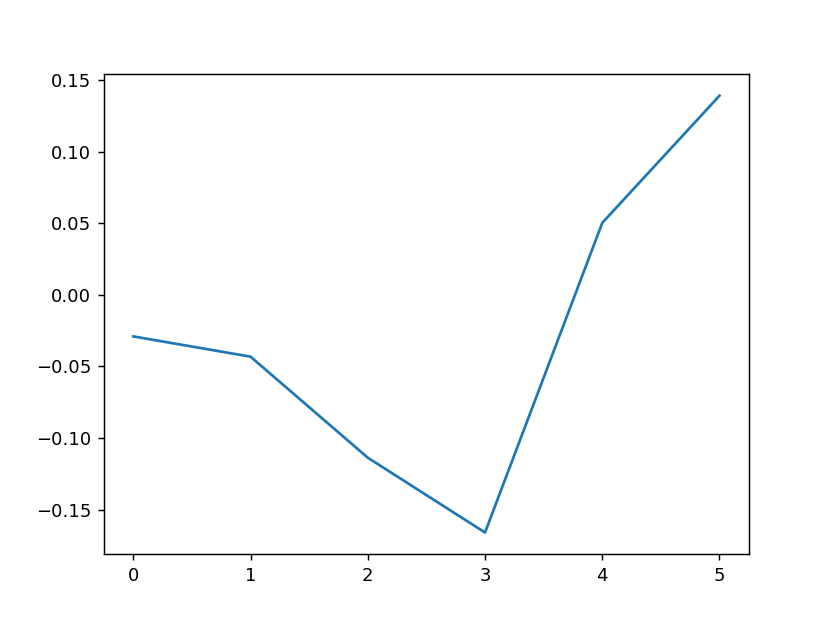

In [35]:
ax, err = fit_error(E_tar, E_prd, 5, dz_list=dz_list[:-1], dz=1, get_error=True)
plt.figure()
plt.plot(err.mean(1))
#fit_error(E_tar, E_prd, 5, dz_list=dz_list[:-1], nz=len(dz_list), dz=2, ax=ax, alpha=.5)

In [36]:
(np.arange(len(E_tar[dr_ind])) + 1).mean()

NameError: name 'dr_ind' is not defined

In [37]:
def old_fit_plot(E_tar, E_prd, dZ, ax=None, prd_colors=['b','g','r', 'o', 'y','c', 'm'], labels=[r'N$_2$', 'CO', 'BF'], shift=0):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    x = dZ+shift
    x_min, x_max = min(x), max(x)
    x_new = np.linspace(x_min, x_max, 300)
    #spline(x, y, x_new)
    ax.plot(dZ+shift, E_tar, color='k', ls='', marker='x')
    ax.plot(x_new, spline(x, E_tar, x_new), color='k')
    for i in range(3):
        ax.plot(dZ+shift, E_prd[i], color=prd_colors[i], ls='', marker='x')
        ax.plot(x_new, spline(x, E_prd[i], x_new), color=prd_colors[i])
    for i in range(3):
        ax.plot([shift-i], E0[i], color=prd_colors[i], marker='o', label=labels[i])
    
fit_plot(E_tar[5], E_prd[5], dZ_N2)

NameError: name 'fit_plot' is not defined

<IPython.core.display.Javascript object>


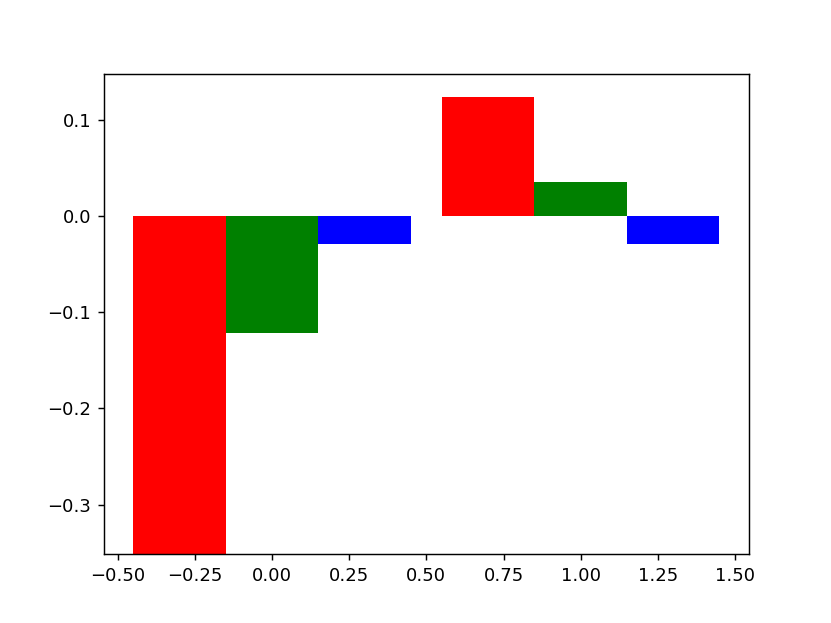

[[-0.02907255 -0.02907218]
 [-0.12170716  0.03529043]
 [-0.35184786  0.1244111 ]]


In [38]:
def fit_error_plot(E_tar, E_prd, ri, ax=None, prd_colors = ['b', 'g', 'r']):
    max_i = 3
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    neighbor_err = np.array([np.take((E_tar[ri] - E_prd[ri][i]), [(6-i)-1, (6-i)+1]) for i in range(max_i)])
    print neighbor_err

    width = 0.3
    widths = [width, 0, -width]
    dZ1 = np.array([0, 1])
    
    for i in range(max_i):
        ax.bar(dZ1+widths[i], neighbor_err[i], width, color=prd_colors[i])
fit_error_plot(E_tar, E_prd, 5)

[-0.94486299 -0.7558904  -0.5669178  -0.3779452  -0.1889726   0.
  0.1889726   0.3779452   0.5669178   0.7558904   0.94486299  1.13383559
  1.32280819  1.51178079  1.70075339]
0.0


<IPython.core.display.Javascript object>


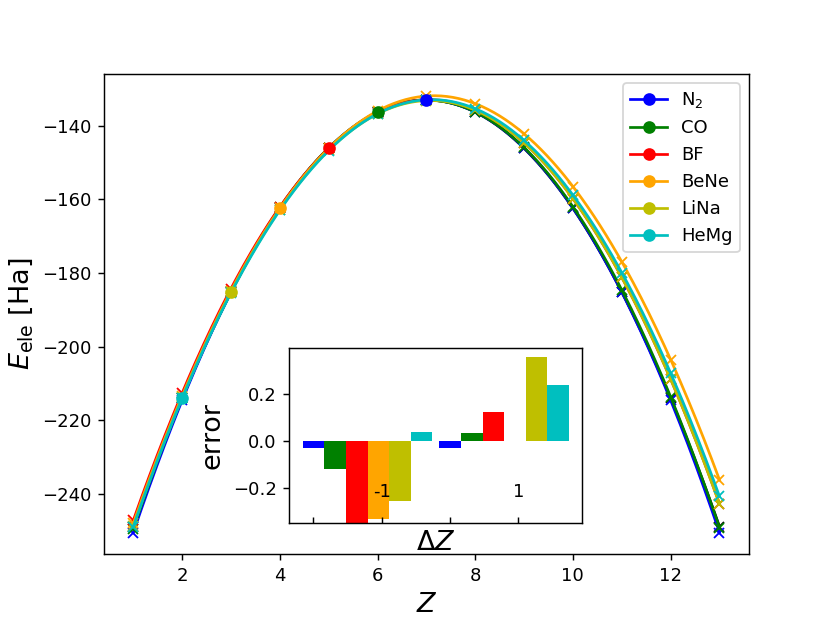

7.0
[[-0.02907255 -0.02907218]
 [-0.12170716  0.03529043]
 [-0.35184786  0.1244111 ]
 [-0.33254397  0.00063102]
 [-0.25868099  0.35903897]
 [ 0.03796697  0.23991943]]


In [45]:
print dR_list
ri=5
dz=1
dz_list = range(6)
#dz_list = [0,1,2,4,5]
print dR_list[ri]
E_tar, E_prd, E0 = E_zz_diag(E_mesh, Xn_meshes, g_list, h_list, dz_list=dz_list, dr_list=dR_list, order=2)



fig = plt.figure()
ax = fig.add_subplot(111)
E_zz_2D_fit(E_tar, E_prd, ri, dz_list=dz_list, ax=ax)

ax_err = fig.add_subplot(224)
#fit_error(E_tar, E_prd, 5, dz_list=dz_list, dz=1)
if dz > 1:
    _, earray = fit_error(E_tar, E_prd, ri, dz_list=dz_list[:-(dz-1)], ax=ax_err, dz=dz, get_error=True)
else:
    _, earray = fit_error(E_tar, E_prd, ri, dz_list=dz_list, ax=ax_err, get_error=True)
    
print earray


err_pos = ax_err.get_position().get_points()
err_xlim = err_pos[:,0].tolist()
err_ylim = err_pos[:,1].tolist()
err_width = err_xlim[1] - err_xlim[0]
err_height = err_ylim[1] - err_ylim[0]
ax_err.set_position([err_xlim[0]-0.2, err_ylim[0]+0.05, err_width, err_height*0.8])

ax_err.tick_params(axis="x",direction="in", pad=-22)
#ax_err.xaxis.set_label_position('top')

#ax_err.xaxis.tick_top()
labels = ['', '', '-%d' % dz, '', '%d' % dz, '']
ax_err.set_xticklabels(labels)
ax_err.set_xlabel(r'$\Delta Z$', fontsize=15)

ax.legend()
ax.set_ylabel(r'$E_{\rm ele}$ [Ha]', fontsize=15)
ax.set_xlabel(r'$Z$', fontsize=15)
ax_err.set_ylabel('error', fontsize=15)

<IPython.core.display.Javascript object>


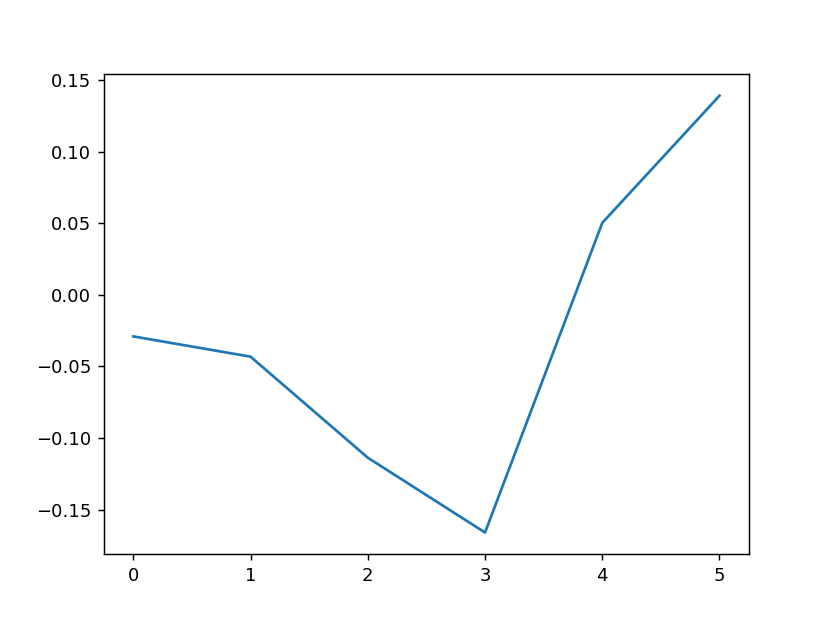

In [42]:
plt.figure()
plt.plot(earray.mean(1))

In [49]:
h_list[0]

array([[-3.1264405 ,  0.13910007,  0.12105   , -0.57477408],
       [ 0.13909635, -3.12644417,  0.12105   , -0.57477408],
       [ 0.12105   ,  0.12105   , -9.47687925, -0.12093628],
       [-0.57477408, -0.57477408, -0.12093628,  0.13920448]])

## senity check

In [64]:
from scipy import interpolate

<IPython.core.display.Javascript object>


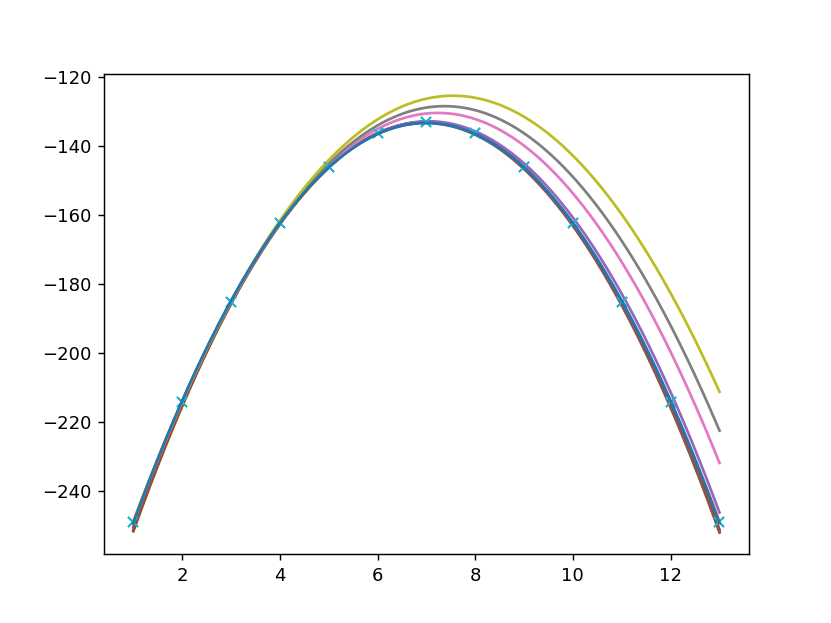

6.99879975995199
6.000200040008002
4.999199839967994
4.000600120024005
2.999599919983997
2.001000200040008
1.0


In [92]:
x = np.arange(1, 14)
y = np.array([
    E_mesh[i, E_mesh.shape[1]-1-i, 5] for i in range(E_mesh.shape[1])
])

fit = interpolate.splrep(x, y, w=np.ones(len(x)), s=0)
xnew = np.linspace(x.min(), x.max(), 5000, endpoint=True)
ynew = interpolate.splev(xnew, fit, der=0)
y_grad = interpolate.splev(xnew, fit, der=1)
y_hess = interpolate.splev(xnew, fit, der=2)

plt.figure()
plt.plot(x, y, ls='', marker='x')
plt.plot(xnew, ynew)

for xi in range(1, 8)[::-1]:
    ind = np.argmin(abs(xnew - xi))
    
    yi = ynew[ind] + y_grad[ind] * (xnew - xnew[ind]) + 0.5 * y_hess[ind] * (xnew - xnew[ind]) ** 2
    plt.plot(xnew, yi)

In [93]:
from scipy.interpolate import UnivariateSpline

<IPython.core.display.Javascript object>


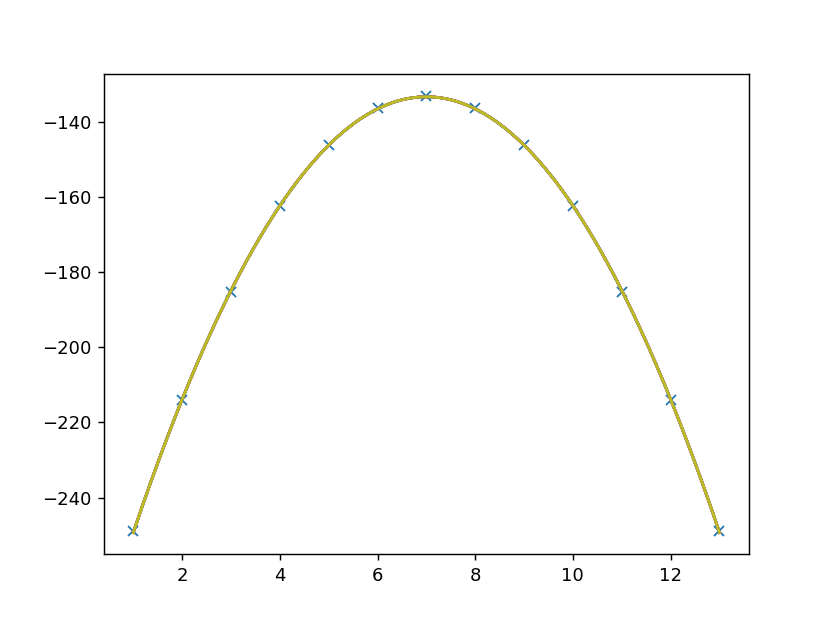

[-2.30764970e+02  3.54524804e+01 -6.44590553e+00 -1.55431223e-15]


In [99]:
fit = UnivariateSpline(x, y)

ynew = fit(xnew)
plt.figure()
plt.plot(x, y, ls='', marker='x')
plt.plot(xnew, ynew)

print fit.derivatives(1.5)

for xi in range(1, 8)[::-1]:
    ind = np.argmin(abs(xnew - xi))
    
    der = fit.derivatives(xnew[ind])
    yi = der[0] + der[1] * (xnew - xnew[ind]) + 0.5 * der[2] * (xnew - xnew[ind]) ** 2
    plt.plot(xnew, yi)

<IPython.core.display.Javascript object>


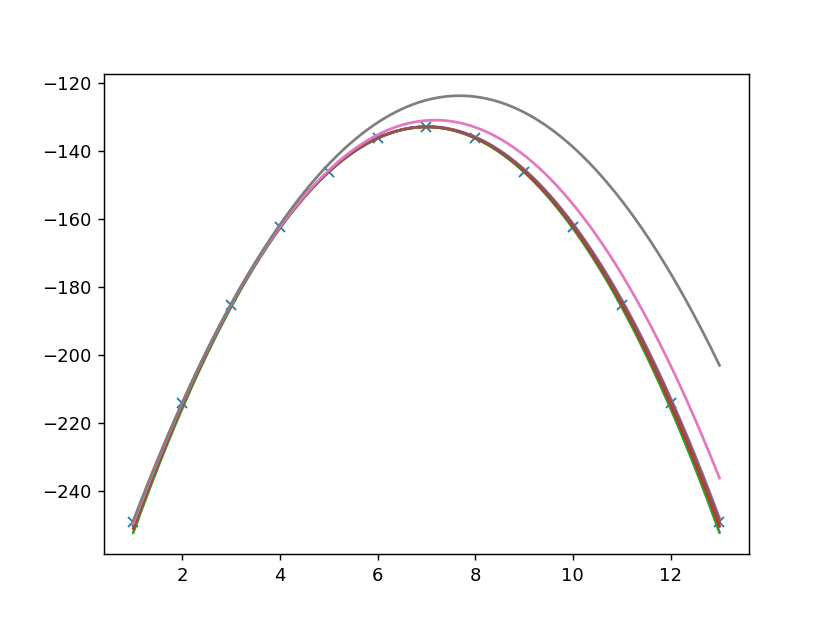

In [117]:
order = 10
fit_coeff = np.polyfit(x,y,order)[::-1]

ynew = np.zeros(len(xnew))
for i, c in enumerate(fit_coeff):
    ynew += c * xnew ** i

plt.figure()
plt.plot(x, y, ls='', marker='x')
plt.plot(xnew, ynew)



for xi in range(2, 8)[::-1]:
    ind = np.argmin(abs(xnew - xi))
    
    y0 = ynew[ind]
    c1 = 0
    for i, c in enumerate(fit_coeff):
        if i > 0:
            c1 += c * i * (xnew[ind]) ** (i - 1)
    c2 = np.zeros(len(xnew))
    for i, c in enumerate(fit_coeff):
        if i > 1:
            c2 += c * i * (i-1) * (xnew[ind]) ** (i - 2)
    yi = y0 + c1 * (xnew - xnew[ind]) + 0.5 * c2 * (xnew - xnew[ind]) ** 2
    plt.plot(xnew, yi)

# Specific N2 plots with highting elements

<IPython.core.display.Javascript object>


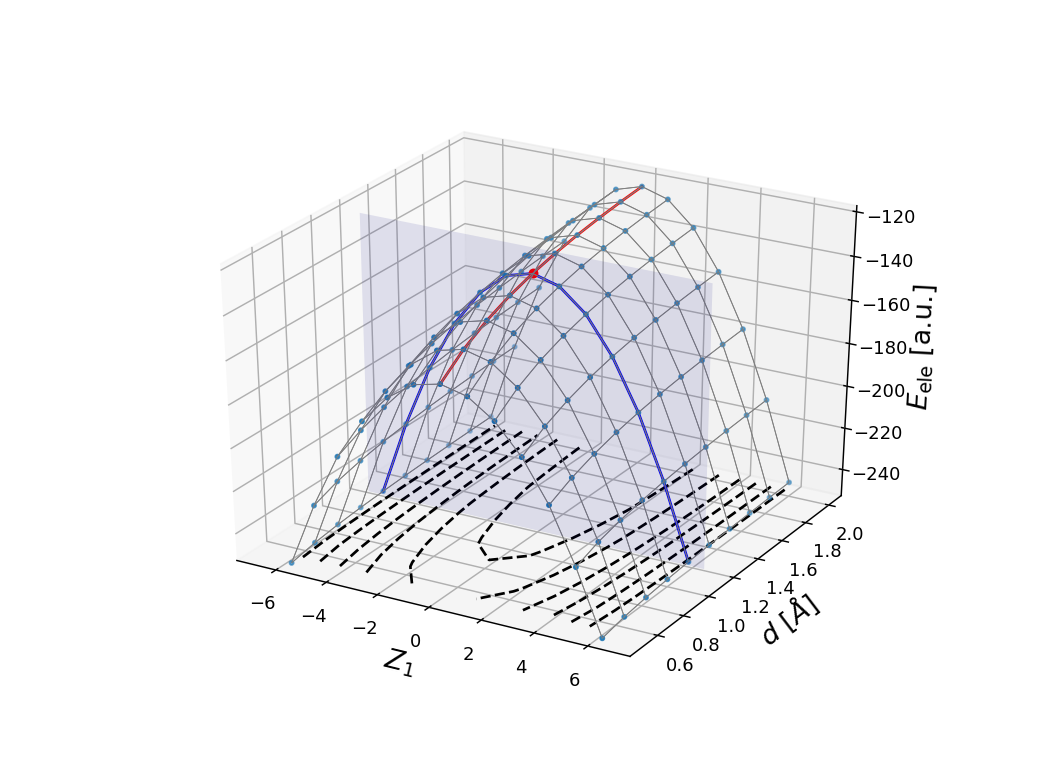

In [92]:
def E_zr(data_N2_ZR, ax=None):
    """ZR 3D inset by parsing ax object
       take numpy data and construct 3D plot elements.
       ax object will be created is nothing is parsed, i.e. new figure
    """
    
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        
    ##############################
    # extract data from npz file #
    ##############################
    dZ, E = data_N2_ZR['X'], data_N2_ZR['E']
    dZ1 = sorted(set(dZ[:,0]))
    dR = sorted(set(dZ[:,1]))
    X, Y = np.meshgrid(dZ1, dR, indexing='ij')
    E_mesh = np.zeros(X.shape)
    for s, e in enumerate(E):
        i = dZ1.index(dZ[s][0])
        j = dR.index(dZ[s][1])
        E_mesh[i,j] = e

    #######################
    # construct plot data #
    #######################
    rz_surface_data = []
    rz_ref_line1 = []
    rz_ref_line2 = []
    ref_point = None
    ref_d = 0.
    for x, y, z in zip(X.ravel(), Y.ravel(), E_mesh.ravel()):

        if (abs(x) < 1E-5):
            rz_ref_line1.append([x, y, z])
        if 1.0 < y <= 1.2:
            if len(rz_ref_line2) == 0:
                rz_ref_line2.append([x, y, z])
            elif abs(y-rz_ref_line2[0][1]) < 1E-3:
                rz_ref_line2.append([x, y, z])
                if abs(x) < 1E-5:
                    ref_d = y
        if ref_d > 0:
            if y == ref_d and abs(x) < 1E-5:
                ref_point = [x,y,z]
            else:
                rz_surface_data.append([x, y, z])
        else:
            rz_surface_data.append([x, y, z])
    
    ##############################
    # reformat data into nparray #
    ##############################
    rz_ref_line1 = np.array(rz_ref_line1)
    rz_ref_line2 = np.array(rz_ref_line2)
    rz_surface_data = np.array(rz_surface_data)
    x, y, z = rz_surface_data.T[0], rz_surface_data.T[1], rz_surface_data.T[2]
    x1, y1, z1 = rz_ref_line1.T[0], rz_ref_line1.T[1], rz_ref_line1.T[2]
    x2, y2, z2 = rz_ref_line2.T[0], rz_ref_line2.T[1], rz_ref_line2.T[2]
    Z = E_mesh
    
    ###############
    # interpolate #
    ###############
    Z_smooth = interp2d(x, y, z)
    min_coord = np.array([
        [0, 1.09], # N2
        [1, 1.16], # CO
        [2, 1.36], # BF
        [3, 2.9],  # BeNe
    ])
    xb, db = min_coord[:,0], min_coord[:,1]
    
    
    ################
    # actual plots #
    ################
    zlim = [-250, -120]
    # surface 
    ax.plot_wireframe(X,Y,Z, color='0.5', linewidth=0.5)
    # underlieing contour
    ax.contour(X, Y, Z, zdir='z', offset=zlim[0], colors='black')
    # surface points
    ax.scatter(x, y, z, s=5)
    # eigenmode 1
    ax.plot(x1, y1, z1, c='red')
    # eigenmode 2
    ax.plot(x2, y2, z2, c='blue')
    # N2 reference point
    ax.scatter([ref_point[0]], [ref_point[1]], [ref_point[2]], c='red')
    # interporlate plot
    #ax.plot(xb, db, np.diag(Z_smooth(xb, db)))
    
    # figure setting
    ax.set_xlabel(r'$Z_1$', fontsize=15)
    ax.set_ylabel(r'$d$ [$\AA$]', fontsize=15)
    ax.set_zlabel(r'$E_{\rm ele}$ [a.u.]', fontsize=15)
    ax.set_zlim(zlim)
    
    ###############################
    # cross section hight surface #
    ###############################
    # need the current plot range data, can only be constructed after plot
    ax.plot_wireframe(X,Y,Z, color='0.5', linewidth=0.5)
    xlim = ax.get_xlim()
    Zp, Xp = np.meshgrid(
        np.linspace(zlim[0], zlim[1], 2, endpoint=True), 
        np.linspace(xlim[0], xlim[-1], 2, endpoint=True)
    )
    Yp = np.ones(Zp.shape) * ref_d
    ax.plot_surface(Xp, Yp, Zp, alpha=0.1, color='blue')
    
E_zr(data_N2_ZR)

<IPython.core.display.Javascript object>


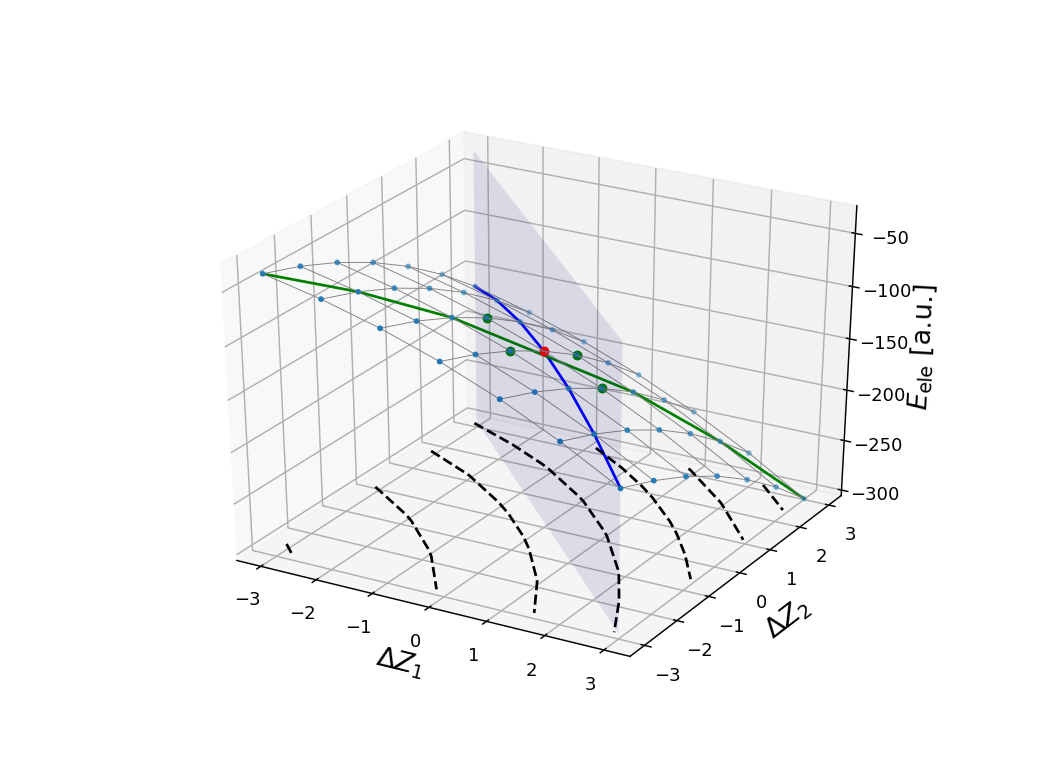

In [29]:
def E_zz(data_N2, ax=None):
    """ZZ 3D inset by parsing ax object
       take numpy data and construct 3D plot elements.
       ax object will be created is nothing is parsed, i.e. new figure
    """
    
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')

    ################
    # process data #
    ################
    dZ, E = data_N2['X'], data_N2['E']
    dZ1 = sorted(set(dZ[:,0]))
    dZ2 = sorted(set(dZ[:,1]))
    X, Y = np.meshgrid(dZ1, dZ2, indexing='ij')
    E_mesh = np.zeros(X.shape)
    for s, e in enumerate(E):
        i = dZ1.index(dZ[s][0])
        j = dZ1.index(dZ[s][1])
        E_mesh[i,j] = e

    ##############################
    # construct 3d plot elements #
    ##############################
    full_surface_data = []
    line_mode1 = []
    line_mode2 = []
    ref_point = None
    ref_point_2 = []

    for x, y, z in zip(X.ravel(), Y.ravel(), E_mesh.ravel()):

        # scatter plot data
        if (abs(x) < 1E-5) and (abs(y) < 1E-5):
            ref_point = [x, y, z]
        else:
            full_surface_data.append([x, y, z])
        if x * y == 0 and ((x+y == -1) or (x+y == 1)):
            ref_point_2.append([x,y,z])

        # normal mode lines
        if abs(x + y) < 1E-5: # dZ1 + dZ2 = 0, mode1
            line_mode1.append([x, y, z])
        elif x == y: # dZ1 == dZ2, mode2
            line_mode2.append([x, y, z])

    # reformate into numpy array
    line_mode1 = np.array(line_mode1)
    line_mode2 = np.array(line_mode2)
    ref_point_2 = np.array(ref_point_2)
    x1, y1, z1 = line_mode1.T[0], line_mode1.T[1], line_mode1.T[2]
    x2, y2, z2 = line_mode2.T[0], line_mode2.T[1], line_mode2.T[2]
    

    #####################
    # contour plot data #
    #####################
    full_surface_data = np.array(full_surface_data)
    fdt = full_surface_data.T
    x, y, z = full_surface_data.T[0], full_surface_data.T[1], full_surface_data.T[2]
    xs = sorted(list(set(x)))
    ys = sorted(list(set(y)))
    X, Y = np.meshgrid(xs, ys, indexing='ij')
    Z = E_mesh.copy()
    
    ##################
    # main 3D figure #
    ##################
    zlim = [-300,-30]
    # surface
    ax.plot_wireframe(X,Y,Z, color='0.5', linewidth=0.5)          
    # grid points
    ax.scatter(x, y, z, s=5)                                      
    # underlieing contour
    ax.contour(X, Y, Z, zdir='z', offset=zlim[0], colors='black') 
    # eigenmode 1
    ax.plot(x1, y1, z1, c='blue')  
    # eigenmode 2
    ax.plot(x2, y2, z2, c='green') 
    # N2 base molecule
    ax.scatter([ref_point[0]], [ref_point[1]], [ref_point[2]], c='red', zorder=100)
    # CN, NO off diagonal molecule
    s = ax.scatter([ref_point_2.T[0]], [ref_point_2.T[1]], [ref_point_2.T[2]], c='green')
    s.set_edgecolors = s.set_facecolors = lambda *args:None # turning off depth transparency
    
    ax.set_xlabel(r'$\Delta Z_1$', fontsize=15)
    ax.set_ylabel(r'$\Delta Z_2$', fontsize=15)
    ax.set_zlabel(r'$E_{\rm ele}$ [a.u.]', fontsize=15)
    ax.set_zlim(zlim)
    
    ###############################
    # cross section hight surface #
    ###############################
    # need the current plot range data, can only be constructed after plot
    xp = sorted(list(set(x1)))
    yp = sorted(list(set(y1)))[::-1]
    Xp, Yp = np.meshgrid(
        np.linspace(xp[0], xp[-1], 2, endpoint=True),
        np.linspace(yp[0], yp[-1], 2, endpoint=True),
        indexing='ij',
    )
    Xp, Zp = np.meshgrid(
        np.linspace(xp[0], xp[-1], 2, endpoint=True),
        np.linspace(zlim[0], zlim[1], 2, endpoint=True), 
    )
    ax.plot_surface(Xp, Yp, Zp, alpha=0.1, color='blue')
E_zz(data_N2_ZZ)

<IPython.core.display.Javascript object>


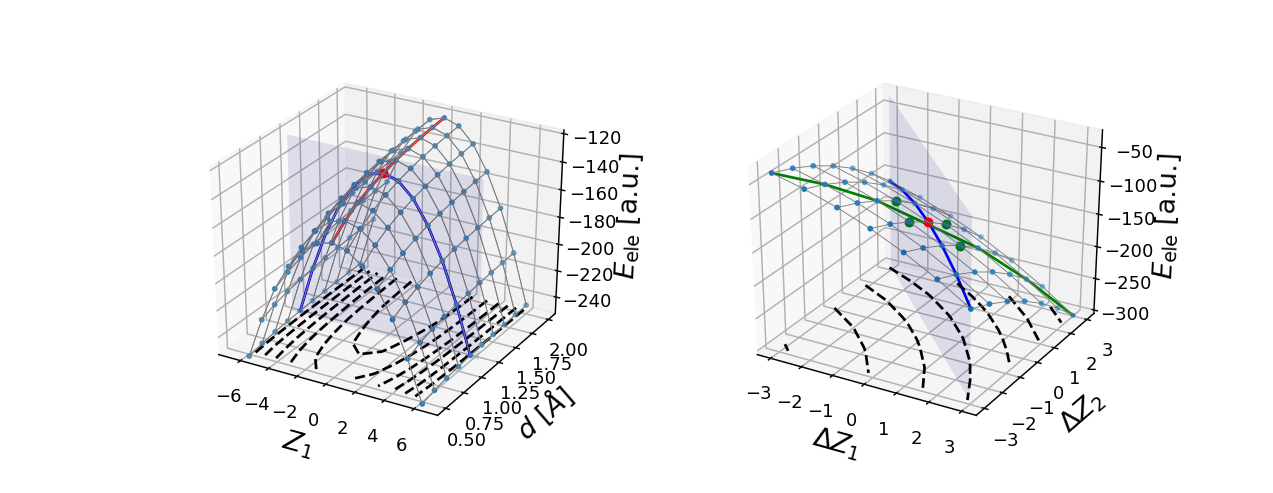

In [30]:
fig = plt.figure(figsize=(9.8,3.8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

E_zr(data_N2_ZR, ax=ax1)
E_zz(data_N2_ZZ, ax=ax2)

# test of free atom energy estimate

In [31]:
def EdZ(dZ):
    return -0.5 * ((7+dZ)**2.4 + (7-dZ)**2.4)

In [32]:
def EdZ2(dZ1, dZ2):
    return -0.5 * ((7+dZ1)**2.4 + (7+dZ2)**2.4)

In [33]:
def EZ2(Z1, Z2):
    return -0.5 * ((Z1)**2.4 + (Z2)**2.4)

In [34]:
dZ = np.arange(-6, 7)

In [35]:
dZ1, dZ2 = np.meshgrid(
    np.arange(-3,4),
    np.arange(-3,4),
)

In [36]:
Z1, Z2 = np.meshgrid(
    np.arange(1, 86),
    np.arange(1, 86),
)

<IPython.core.display.Javascript object>


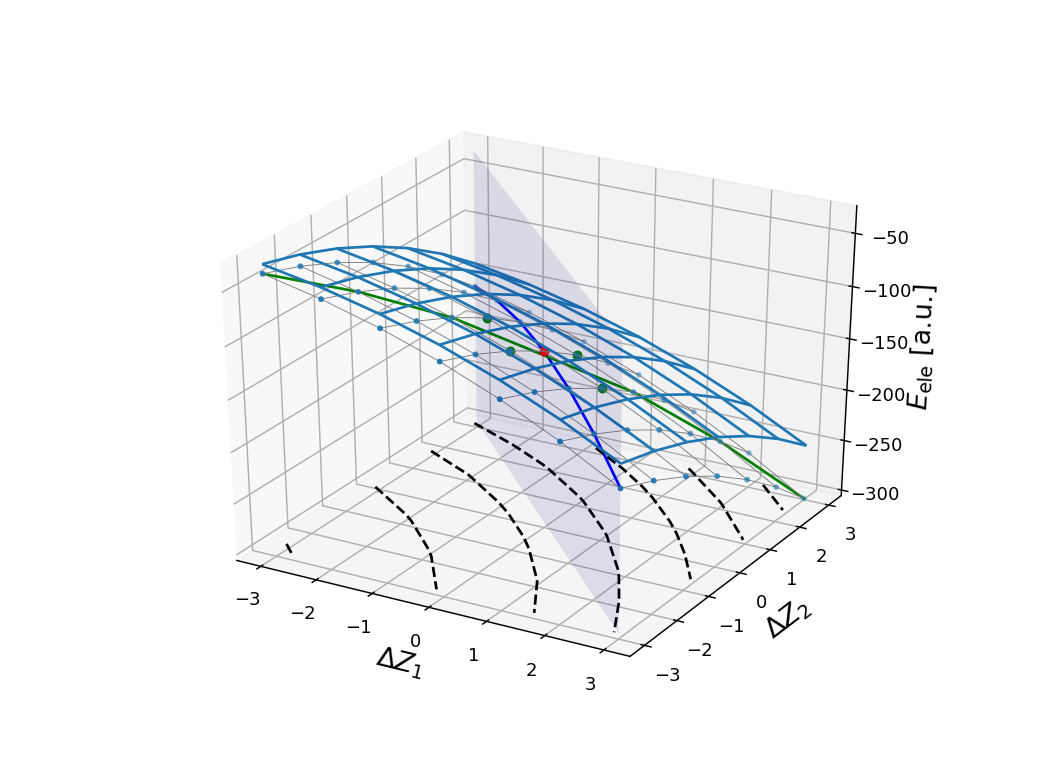

In [37]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(dZ1, dZ2, EdZ2(dZ1, dZ2))
E_zz(data_N2_ZZ, ax=ax)

<IPython.core.display.Javascript object>


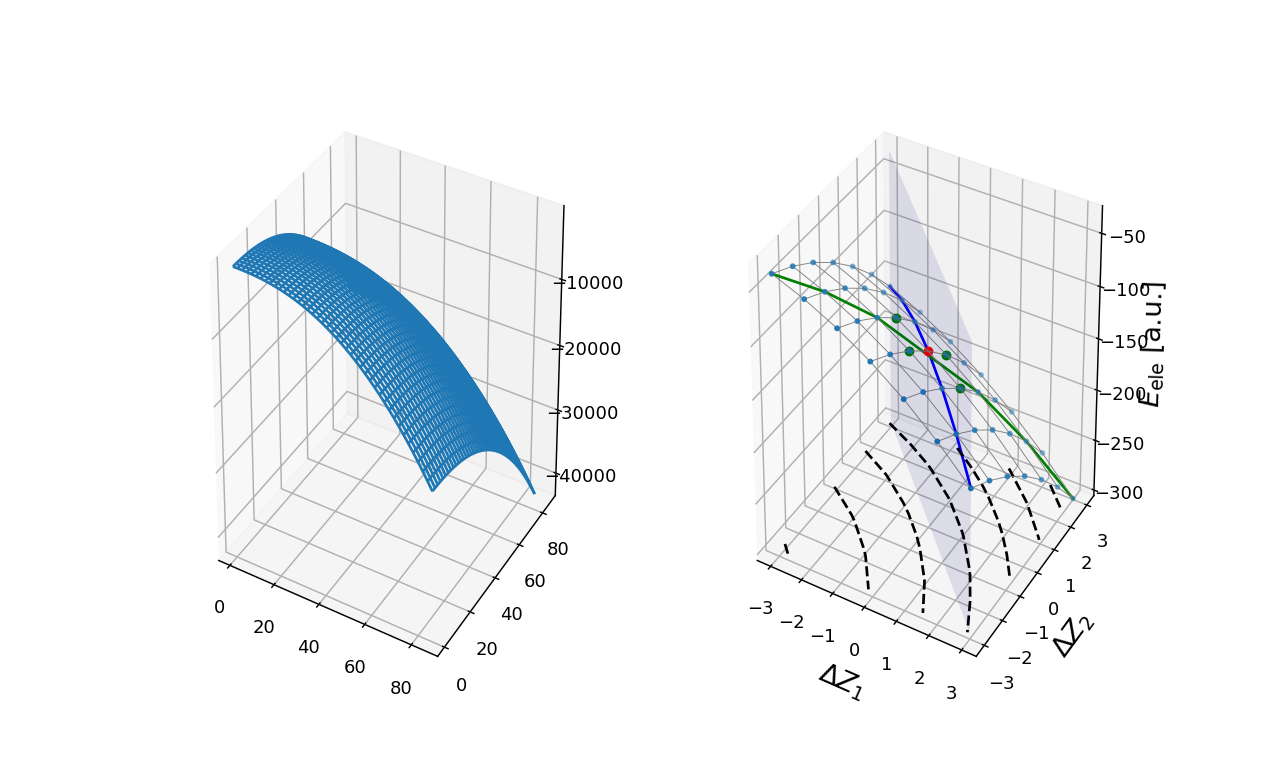

In [38]:
fig = plt.figure(figsize=(9.8,6))
ax1 = fig.add_subplot(121, projection='3d')
points = np.vstack([Z1.ravel(), Z2.ravel(), EZ2(Z1, Z2).ravel()]).T
ax1.plot_wireframe(Z1, Z2, EZ2(Z1, Z2))
#ax1.scatter(points[:,0], points[:,1], points[:,2], s=.1)

ax2 = fig.add_subplot(122, projection='3d')
E_zz(data_N2_ZZ, ax=ax2)